In [14]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.explainability_tools import ShapFeatureImportanceDisplay, ShapDisplay
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import time
import numpy as np
import pandas as pd
import shap

import matplotlib.pyplot as plt


In [2]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

In [30]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    # CategoricalVariable([
    #     "type_A", "type_B", "type_C", "type_D", 
    #     "type_E", "type_F", "type_G", "type_H", 
    #     "type_I", "type_J", "type_K", "type_L",
    # ]),
    CategoricalVariable([
        "A", "B", "C", "D", 
        "E", "F", "G", "H", 
        "I", "J", "K", "L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 250
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

x_ref, _ = ds.sample_valid_x(1000)
y_ref = [f_obj(x_ref[i]) for i in range(len(x_ref))]
X_ref = np.array(x_ref)
y_ref = np.array(y_ref)

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$\tilde{I}$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

Ground truth model
RMSE: 0.0000
rRMSE: 0.0000
CPU times: user 5.53 s, sys: 139 ms, total: 5.67 s
Wall time: 5.68 s


In [31]:
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 20.699912786483765
Surrogate model
RMSE: 0.0000
rRMSE: 0.0144


In [43]:
class ModelMod:
    def __init__(self, model):
        self.model = model

    def transform_predict(self, x_df):
        x_df_inverse = x_df.copy()
        x_df_inverse[0] = x_df_inverse[0].str.replace("type_", "")
        x_df_inverse[0] = x_df_inverse[0].apply(lambda x: float(x))
        return self.model.predict_values(np.array(x_df_inverse))


In [50]:
X_tr_mod = pd.DataFrame(X_tr)
X_tr_mod[0] = X_tr_mod[0].apply(lambda x: f"type_{int(x)}") 
X_tr_mod[0] = X_tr_mod[0].astype(str) 
X_tr_mod

,0,1,2
0,type_11,19.767490,1.808039
1,type_10,11.897434,1.079519
2,type_11,14.456693,1.494840
3,type_11,18.835038,1.219952
4,type_7,16.276426,1.092540
...,...,...,...
195,type_4,13.696755,1.765917
196,type_2,12.814490,1.801102
197,type_1,19.716800,1.226549
198,type_3,14.236006,1.370332


In [51]:
X_tr_mod.dtypes

0     object
1    float64
2    float64
dtype: object

In [52]:
sm_mod = ModelMod(sm)
sm_mod.transform_predict(X_tr_mod)

array([[5.33619079e-04],
       [8.72648069e-04],
       [3.05358247e-04],
       [1.01392635e-03],
       [2.21351271e-03],
       [1.19114952e-03],
       [7.34854274e-04],
       [2.03645441e-03],
       [4.32728749e-04],
       [4.13776919e-04],
       [4.23200460e-03],
       [5.94409115e-04],
       [3.87151352e-04],
       [8.39419351e-04],
       [5.54604522e-03],
       [8.87122651e-04],
       [6.93585408e-04],
       [1.69848058e-03],
       [2.03980287e-03],
       [1.01108229e-03],
       [5.89735861e-04],
       [4.05469175e-04],
       [1.16070242e-04],
       [1.45679077e-03],
       [7.38573688e-04],
       [1.73288129e-03],
       [1.07615234e-03],
       [3.89644326e-04],
       [2.40163099e-04],
       [9.04072704e-04],
       [1.89247224e-03],
       [1.88478358e-03],
       [3.21066445e-04],
       [5.35693805e-04],
       [3.13005125e-04],
       [1.04959947e-03],
       [3.79063517e-04],
       [4.95444221e-04],
       [1.58740232e-04],
       [1.47395948e-04],


In [55]:
explainer = shap.ExactExplainer(sm_mod.transform_predict, X_tr_mod)
shap_values = explainer(X_tr_mod)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [29]:
X_tr_mod = X_tr.copy()

In [9]:
shap_values_arr = shap_values.values

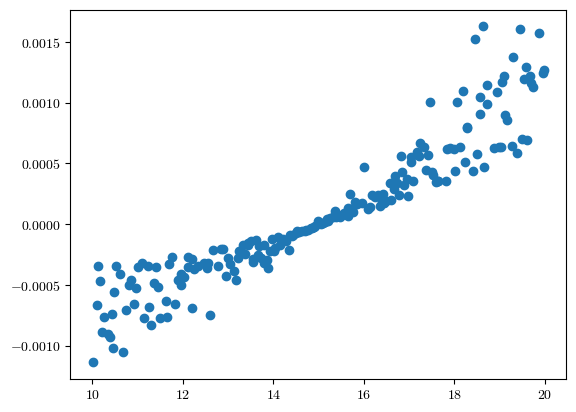

In [16]:
plt.scatter(X_tr[:, 1], shap_values_arr[:, 1])

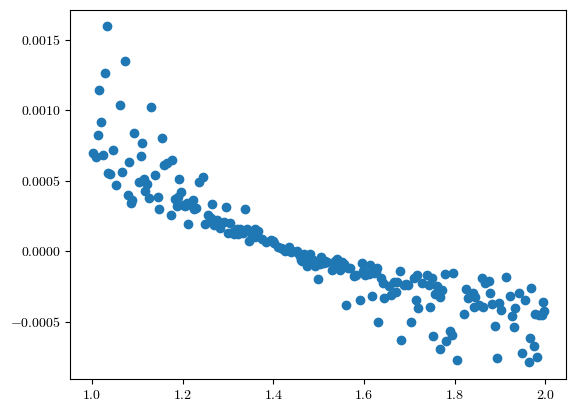

In [17]:
plt.scatter(X_tr[:, 2], shap_values_arr[:, 2])

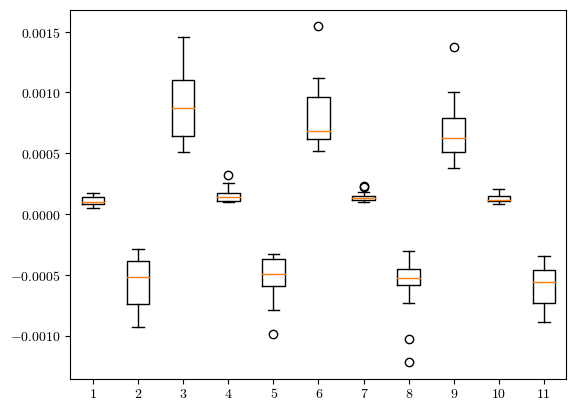

In [27]:
cat_shap_values = [shap_values_arr[X_tr[:, 0] == i][:, 0] for i in range(1, 12)]
plt.boxplot(cat_shap_values)
plt.show()

In [23]:
cat_shap_values

[array([[ 1.73936872e-04,  1.24236703e-03, -6.51916191e-05],
        [ 1.33823846e-04,  6.18424190e-04, -1.04581209e-04],
        [ 8.46618606e-05, -5.72754026e-05, -4.04977514e-04],
        [ 1.43471465e-04,  8.98852854e-04, -3.20749124e-04],
        [ 1.68127660e-04,  1.15939438e-03, -6.98058432e-05],
        [ 1.02396601e-04, -2.18779114e-04,  3.07345588e-04],
        [ 9.48190884e-05,  9.04094572e-05, -3.98836529e-04],
        [ 5.40295936e-05, -4.96578886e-04, -1.90776277e-04],
        [ 6.75401850e-05, -5.15320739e-04, -2.22221513e-05],
        [ 1.46001253e-04,  5.53045849e-04,  5.10253483e-04],
        [ 8.72611594e-05, -1.25440800e-04, -1.69780091e-04]]),
 array([[-3.61070974e-04, -1.39129013e-04, -2.24782395e-04],
        [-9.29247270e-04,  3.42854747e-04,  6.84639633e-04],
        [-3.72901184e-04, -3.49090910e-04, -3.22093356e-06],
        [-4.25626740e-04,  6.59209277e-05, -2.97813258e-04],
        [-4.19686498e-04, -4.61268058e-04,  1.90977223e-04],
        [-5.08577386e-

In [19]:
X_tr[X_tr[:, 0] == 1]

array([[ 1.        , 19.95685628,  1.46138519],
       [ 1.        , 17.841198  ,  1.4928017 ],
       [ 1.        , 14.63565626,  1.93386462],
       [ 1.        , 19.1203242 ,  1.61752361],
       [ 1.        , 19.70052274,  1.46429364],
       [ 1.        , 13.933571  ,  1.23048872],
       [ 1.        , 15.56884265,  1.84235015],
       [ 1.        , 10.80270637,  1.74986814],
       [ 1.        , 11.45361334,  1.48198894],
       [ 1.        , 17.04687838,  1.19221079],
       [ 1.        , 14.22041466,  1.60148815]])

In [20]:
X_tr[:, 0].max()

11.0

In [11]:
X_tra


array([[ 2.        , 13.51341292,  1.86750733],
       [ 2.        , 16.73854092,  1.02526476],
       [ 3.        , 11.83364887,  1.47780052],
       [ 9.        , 12.7738613 ,  1.98649745],
       [ 4.        , 10.10896884,  1.45547512],
       [ 4.        , 14.77058183,  1.32667181],
       [ 4.        , 16.84405254,  1.35126341],
       [ 0.        , 16.00273783,  1.02996651],
       [ 9.        , 17.89772073,  1.96362854],
       [ 7.        , 16.41631972,  1.71556489],
       [ 7.        , 10.39546819,  1.03667391],
       [11.        , 18.00080097,  1.51170436],
       [ 6.        , 15.4165339 ,  1.9742144 ],
       [ 8.        , 19.48697505,  1.57909875],
       [ 2.        , 11.41870066,  1.45165292],
       [ 2.        , 15.63958019,  1.94115793],
       [ 1.        , 19.95685628,  1.46138519],
       [ 3.        , 18.04938306,  1.39519402],
       [ 1.        , 17.841198  ,  1.4928017 ],
       [10.        , 18.55702006,  1.17737751],
       [ 2.        , 10.8461711 ,  1.212

In [10]:
shap_values_arr

array([[-3.61070974e-04, -1.39129013e-04, -2.24782395e-04],
       [-9.29247270e-04,  3.42854747e-04,  6.84639633e-04],
       [ 6.26205549e-04, -6.52332527e-04, -5.96413811e-05],
       [ 3.94329088e-04, -3.41084753e-04, -4.56000387e-04],
       [ 1.02573222e-04, -6.62111005e-04, -1.50667900e-05],
       [ 1.61447283e-04, -5.05618666e-05,  1.56146528e-04],
       [ 1.94907355e-04,  4.26907037e-04,  1.37969760e-04],
       [ 1.25482686e-03,  4.66691683e-04,  1.26298204e-03],
       [ 6.25710667e-04,  6.28311461e-04, -7.90288027e-04],
       [ 1.34026132e-04,  2.51463096e-04, -3.44570194e-04],
       [ 1.34973641e-04, -9.31360230e-04,  5.56747538e-04],
       [-6.62241585e-04,  4.41543066e-04, -8.30396142e-05],
       [ 6.31709089e-04,  7.36648179e-05, -6.73520609e-04],
       [-7.20448849e-04,  7.00894814e-04, -1.73638375e-04],
       [-3.72901184e-04, -3.49090910e-04, -3.22093356e-06],
       [-4.25626740e-04,  6.59209277e-05, -2.97813258e-04],
       [ 1.73936872e-04,  1.24236703e-03